In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import requests 

import seaborn as sns

from fiona.crs import from_epsg

import statsmodels.api as sm
import statsmodels.discrete.discrete_model as sm_dm

from sklearn.neighbors import KNeighborsRegressor

### API-Based ACS

https://api.census.gov/data/2019/acs/acs1/pums?tabulate=weight(PWGTP)&col+HISPEED&row+RACBLK&SCHL=24

In [2]:
resp = requests.get("https://api.census.gov/data/2019/acs/acs5/profile?get=NAME&for=state:*")
fips = {int(v[1]) : v[0] for v in resp.json()[1:]}

### At the individual level -- Integrated Public Use Microdata Samples

This sample needs to be constructed with your own account here: https://usa.ipums.org/usa/index.shtml

In [3]:
ipums = pd.read_csv("../data/ipums_2019.csv.gz", 
                    usecols = ["YEAR", "SAMPLE", "PERWT", "HHWT", 
                               "STATEFIP", "COUNTYFIP", "METRO", "MET2013", "CITY",
                               "PUMA", "GQ", "HHINCOME", "CILAPTOP", "CISMRTPHN", "CITABLET", #"CIHAND", 
                               "CINETHH", "CIDATAPLN", "CIHISPEED", "CISAT", "CIDIAL", "CIOTHSVC", 
                               "SEX", "AGE", "RACE", "HISPAN", "RACBLK", "RACWHT", "EDUC", 
                               "INCTOT", "FTOTINC", "INCWAGE", "INCEARN", "POVERTY"])

ipums["state"] = ipums.STATEFIP.replace(fips)
ipums.rename(columns = {"STATEFIP" : "STATE", "COUNTYFIP" : "COUNTY"}, inplace = True)

Making the codes comprehensible.

In [4]:
ipums["C"] = 1
ipums["BA"] = ipums["EDUC"] >= 10
ipums["logFInc"]  = np.log(ipums["FTOTINC"]) .replace({-np.inf : np.nan})
ipums["logInc"]   = np.log(ipums["INCTOT"])  .replace({-np.inf : np.nan})
ipums["logHHInc"] = np.log(ipums["HHINCOME"]).replace({-np.inf : np.nan})

ipums["isGQ"] = ipums.GQ > 2

ipums["sex"]  = np.where(ipums.SEX == 1,      "Male", "Female")
ipums["blk"]  = np.where(ipums.RACBLK == 2,   "Black", "Non-Black")
ipums["hisp"] = np.where(ipums.HISPAN > 0,    "Hispanic", "Non-Hispanic")
ipums["wht"]  = np.where(ipums.RACWHT == 2,   "White", "Non-White")
ipums["pov"]  = np.where(ipums.POVERTY < 100, "Below Poverty Line", "Above Poverty Line")

ipums["any_access"]  = ipums.CINETHH.isin([1, 2]).astype(int)
ipums["broadband"] = ipums.CIHISPEED.isin(range(10, 20)).astype(int)
ipums["data_plan"] = (ipums.CIDATAPLN == 1).astype(int)
ipums["satellite"] = (ipums.CISAT == 1).astype(int)

ipums["laptop"] = ipums.CILAPTOP == 1
ipums["smartphone"] = ipums.CISMRTPHN == 1

/Users/jsaxon/opt/anaconda3/envs/geo/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/jsaxon/opt/anaconda3/envs/geo/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Levels by state, to compare with CPS/NTIA

Household and person-weighted variables.  Compare these to ACS estimates.

In [5]:
def h_weighted_mean(grp): return grp._get_numeric_data().multiply(grp['HHWT'], axis=0).sum()/grp['HHWT'].sum()
def p_weighted_mean(grp): return grp._get_numeric_data().multiply(grp['PERWT'], axis=0).sum()/grp['PERWT'].sum()

In [6]:
ipums.groupby("state").apply(h_weighted_mean)\
     [["any_access", "broadband", "data_plan", "laptop", "smartphone"]].round(3)

,any_access,broadband,data_plan,laptop,smartphone
state,,,,,
Alabama,0.862,0.619,0.767,0.722,0.861
Alaska,0.881,0.663,0.810,0.778,0.901
Arizona,0.899,0.720,0.797,0.801,0.899
Arkansas,0.850,0.588,0.753,0.694,0.857
California,0.922,0.770,0.842,0.829,0.918
Colorado,0.936,0.790,0.853,0.864,0.916
Connecticut,0.912,0.791,0.813,0.816,0.875
Delaware,0.918,0.770,0.848,0.814,0.892
District of Columbia,0.868,0.759,0.808,0.805,0.867


### Cities don't work, so use CBSAs.

In [7]:
cbsa = ["new_york", "los_angeles", "chicago", "dallas-fort_worth", "houston", 
        "philadelphia", "washington", "miami", "atlanta", "boston", 
        "san_francisco", "riverside", "phoenix", "detroit", "seattle", 
        "minneapolis", "san_diego", "tampa", "st_louis", "denver"]

cbsa_dict = {
    35620 : "new_york", 31080 : "los_angeles", 16980 : "chicago", 19100 : "dallas-fort_worth", 26420 : "houston", 
    37980 : "philadelphia", 47900 : "washington", 33100 : "miami", 12060 : "atlanta", 14460 : "boston", 
    41860 : "san_francisco", 40140 : "riverside", 38060 : "phoenix", 19820 : "detroit", 42660 : "seattle", 
    33460 : "minneapolis", 41740 : "san_diego", 45300 : "tampa", 41180 : "st_louis", 19740 : "denver"
}

ipums.query("(MET2013 in @cbsa_dict) & (GQ in [1, 2])", inplace = True)
ipums["cbsa"] = ipums.MET2013.replace(cbsa_dict)

In [8]:
agg = ipums.groupby("cbsa").apply(h_weighted_mean)\
           [["any_access", "broadband", "data_plan", "laptop", "smartphone"]].round(3)
    
agg = agg.reindex(cbsa)
agg.index = agg.index.str.replace("_", " ").str.title()
agg.sort_values("broadband", ascending = False)

,any_access,broadband,data_plan,laptop,smartphone
cbsa,,,,,
Seattle,0.969,0.860,0.908,0.901,0.949
Boston,0.953,0.852,0.876,0.876,0.917
San Francisco,0.957,0.849,0.911,0.891,0.948
Washington,0.957,0.848,0.885,0.898,0.946
San Diego,0.967,0.846,0.903,0.891,0.948
Denver,0.961,0.839,0.895,0.890,0.941
Philadelphia,0.939,0.821,0.859,0.847,0.912
Minneapolis,0.951,0.817,0.865,0.883,0.933
Atlanta,0.939,0.801,0.869,0.864,0.938


### Digital Divides

In [9]:
divide = []
for v, label, low, high in [["sex",  "Sex",       "Female", "Male"],
                            ["blk",  "Race",      "Black", "Non-Black"],
                            ["hisp", "Ethnicity", "Hispanic", "Non-Hispanic"],
                            ["pov",  "Poverty",   "Below Poverty Line", "Above Poverty Line"]]:
    
    X = ipums.groupby(["cbsa", v]).apply(p_weighted_mean).broadband.unstack()
    X["Δ" + label] = X[high] - X[low]
    divide.append(X)


divide = pd.concat(divide, axis = 1).round(3)
# divide = divide.filter(regex = "Δ", axis = 1)

divide.index = divide.index.str.replace("_", " ").str.title()
divide.sort_values(by = "ΔRace", ascending = False, inplace = True)

In [10]:
ipums_inc = ipums[["cbsa", "broadband", "blk", "hisp", "sex", 
                   "logHHInc", "BA", "AGE", "C", "PERWT"]].dropna()
ipums_inc["BA1000"] = ipums_inc["BA"] * 1000
ipums_inc["age_dec"] = (ipums_inc["AGE"] // 10).astype(int) * 1000

In [11]:
def knn_divide(v, label, A, B, exog = ["logHHInc", "age_dec"]):

    knn_divide = {}
    for c in cbsa:

        dfA = ipums_inc.query(f"(cbsa == '{c}') & ({v} == '{A}')").reset_index(drop = True)
        dfB = ipums_inc.query(f"(cbsa == '{c}') & ({v} == '{B}')").reset_index(drop = True)

        knn = KNeighborsRegressor(n_neighbors = 10, weights = "distance")

        knn.fit(dfA[exog], dfA.broadband)

        dfB["broadband_A_pred"] = knn.predict(dfB[exog])
        dfB["broadband_diffAB_pred"] = dfB["broadband_A_pred"] - dfB["broadband"]
        knn_divide[c] = (dfB["broadband_diffAB_pred"] * dfB["PERWT"]).sum() / dfB["PERWT"].sum()
    
    knn_divide =  pd.Series(knn_divide)
    knn_divide.index = knn_divide.index.str.replace("_", " ").str.title()
    
    knn_divide.name = "Δk " + label

    return knn_divide

In [12]:
exog = ["logHHInc", "age_dec"]

race_divide = knn_divide("blk",  "Race",      "Non-Black",    "Black",    exog = exog)
sex_divide  = knn_divide("sex",  "Sex",       "Male",         "Female",   exog = exog)
ethn_divide = knn_divide("hisp", "Ethnicity", "Non-Hispanic", "Hispanic", exog = exog)

knn_divides = pd.concat([race_divide, sex_divide, ethn_divide], axis = 1).round(3)

In [13]:
all_divide = divide.join(knn_divides)

all_divide = all_divide[['Female', 'Male', 'ΔSex', 'Δk Sex',
                         'Black', 'Non-Black', 'ΔRace', 'Δk Race', 
                         'Hispanic', 'Non-Hispanic', 'ΔEthnicity', 'Δk Ethnicity',
                         'Above Poverty Line', 'Below Poverty Line', 'ΔPoverty']]

In [14]:
all_divide.filter(regex = "Δ", axis = 1).corr().round(3)\
           .style.background_gradient(axis=None, vmin=0, vmax=1, cmap="viridis").format("{:.3f}")

,ΔSex,Δk Sex,ΔRace,Δk Race,ΔEthnicity,Δk Ethnicity,ΔPoverty
ΔSex,1.000,0.396,0.465,0.527,-0.451,-0.520,-0.017
Δk Sex,0.396,1.000,0.033,0.584,0.096,0.341,0.050
ΔRace,0.465,0.033,1.000,0.740,-0.429,-0.460,0.490
Δk Race,0.527,0.584,0.740,1.000,-0.394,-0.225,0.340
ΔEthnicity,-0.451,0.096,-0.429,-0.394,1.000,0.847,-0.106
Δk Ethnicity,-0.520,0.341,-0.460,-0.225,0.847,1.000,0.004
ΔPoverty,-0.017,0.050,0.490,0.340,-0.106,0.004,1.000


In [15]:
all_divide[["Δk Race", "ΔRace"]].sort_values("Δk Race", ascending = False)

,Δk Race,ΔRace
cbsa,,
Detroit,0.107,0.162
Miami,0.104,0.094
Tampa,0.096,0.094
Philadelphia,0.079,0.120
Chicago,0.065,0.117
Phoenix,0.064,0.047
Boston,0.063,0.088
New York,0.059,0.074
St Louis,0.053,0.126


In [16]:
all_divide[["Δk Ethnicity", "ΔEthnicity"]].sort_values("Δk Ethnicity", ascending = False).head(5)

,Δk Ethnicity,ΔEthnicity
cbsa,,
Phoenix,0.159,0.151
Denver,0.123,0.129
Dallas-Fort Worth,0.122,0.134
Boston,0.113,0.126
Houston,0.096,0.121


In [17]:
all_divide[["Δk Sex", "ΔSex"]].sort_values("Δk Sex", ascending = False).head(5)

,Δk Sex,ΔSex
cbsa,,
Tampa,0.022,0.018
Miami,0.021,0.010
Phoenix,0.019,0.002
Seattle,0.016,0.014
Atlanta,0.015,0.006


In [18]:
ipums["logHHInc_cat"] = ipums.logHHInc.fillna(-1).astype(int)

<AxesSubplot:xlabel='logHHInc_cat'>

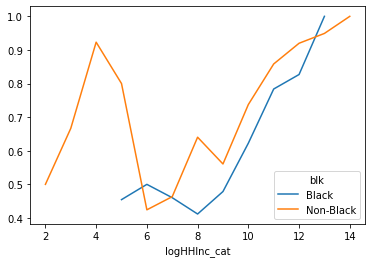

In [19]:
ipums.query("(cbsa == 'detroit') & (logHHInc_cat > 1)")\
     .groupby(["logHHInc_cat", "blk"]).broadband.mean().unstack().plot()

### Cities

* https://usa.ipums.org/usa-action/variables/CITY#codes_section
* Starting from Houston (and then San Antonio, San Diego, Dallas, San Jose, etc.), they're irregularly available 

In [20]:
cities = ["new_york", "los_angeles", "chicago", "houston", "phoenix",
          "philadelphia", "san_antonio", "san_diego", "dallas",
          "san_jose", "austin", "jacksonville", "san_francisco", "columbus",
          "fort_worth", "indianapolis", "charlotte", "seattle", "denver", "washington"]

city_dict = {4610 : "new_york", 3730 : "los_angeles",  1190 : "chicago",     2890 : "houston", 5350 : "phoenix",  
             5330 : "philadelphia", 6230 : "san_antonio", 6270 : "san_diego", 1590 : "dallas", 6310 : "san_jose",
              490 : "austin", 3110 : "jacksonville", 6290 : "san_francisco", 1450 : "columbus", 2350 : "fort_worth",
             2990 : "indianapolis", 1090 : "charlotte", 6430 : "seattle", 1710 : "denver", 7230 : "washington"}